## zipファイルの解凍

In [1]:
import os
import zipfile

titanic_dir = './data/titanic/'

# フォルダ''./data/titanic/'が存在しない場合にzipの解凍
if not os.path.exists(titanic_dir):
    # titanic.zipを解凍
    with zipfile.ZipFile('./data/titanic.zip','r') as file:
        # /titanicディレクトリを作りその中に解凍ファイルを作製
        file.extractall(titanic_dir)

In [2]:
# 解凍したデータフォルダの構造を確認する
!ls ./data/titanic

gender_submission.csv  test.csv  train.csv


## EDA

In [3]:
import numpy as np
import pandas as pd

# データの読み込み
train = pd.read_csv('./data/titanic/train.csv')
test = pd.read_csv('./data/titanic/test.csv')
sub = pd.read_csv('./data/titanic/gender_submission.csv')    # サンプルの予測データ

# データの確認
print(train.shape)
train.head()

(891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
print(test.shape)
test.head()

(418, 11)


PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [5]:
# データ形式の確認
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
import pandas_profiling

train.profile_report()

## 各特徴量について目的変数との関係を確認する

概要を確認したので各特徴量について目的変数のSurvivedとの関係を確認します。

In [7]:
# 説明変数の確認
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def plot_count(feature, title, df, size=1):
    """クラス/特徴量をプロットする
    Pram:
        feature : 分析するカラム
        title : グラフタイトル
        df : プロットするデータフレーム
        size : デフォルト 1.
    """
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    # 最大20カラムをヒストグラムで表示
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        # サイズ2以上の時、行名を90°回転し、表示
        plt.xticks(rotation=90, size=8)
    # データ比率の表示
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()  

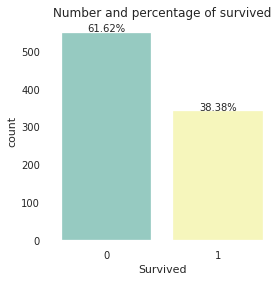

In [8]:
# Survivedの比率を確認する
plot_count(feature='Survived', title='survived', df=train, size=1)

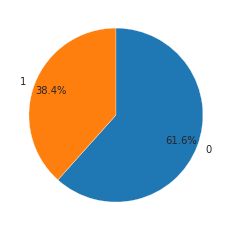

In [9]:
# 円グラフで可視化
plt.pie(
    train['Survived'].value_counts(),    # データの出現頻度
    labels=train['Survived'].value_counts().index,    # ラベル名の指定
    counterclock=False,    # データを時計回りに入れる
    startangle=90,          # データの開始位置 90の場合は円の上から開始
    autopct='%1.1f%%',      # グラフ内に構成割合のラベルを小数点1桁まで表示
    pctdistance=0.8         # ラベルの表示位置
)

plt.show()

生存者の方が少ないデータです

In [10]:
def plot_count2(feature, hue, title, df, size=1):
    """クラス/特徴量をプロットする
    Pram:
        feature : 分析するカラム
        title : グラフタイトル
        hue : 各軸をさらに分割して集計する列名
        df : プロットするデータフレーム
        size : デフォルト 1.
    """
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    # 最大20カラムをヒストグラムで表示
    g = sns.countplot(df[feature], hue=df[hue], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 3):
        # サイズ2以上の時、行名を90°回転し、表示
        plt.xticks(rotation=90, size=8)
    # 表示データ全体の割合の表示
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()  

data count
 Float64Index([24.0, 22.0, 18.0, 19.0, 30.0, 28.0, 21.0, 25.0, 36.0, 29.0], dtype='float64')
Null count  177


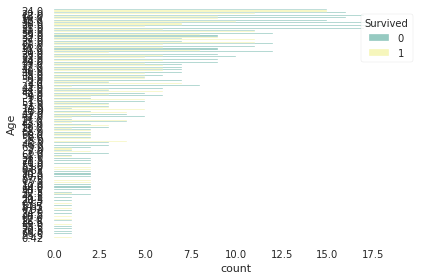

In [11]:
# Ageと目的変数の関係
print('data count\n', train['Age'].value_counts().sort_values(ascending=False).index[:10])    # データの出現数を上位10個表紙
print('Null count ', train['Age'].isnull().sum())

sns.countplot(data=train, y='Age', hue='Survived', order = train['Age'].value_counts().index[:], palette='Set3')
plt.legend(loc='upper right', title='Survived')
plt.tight_layout()

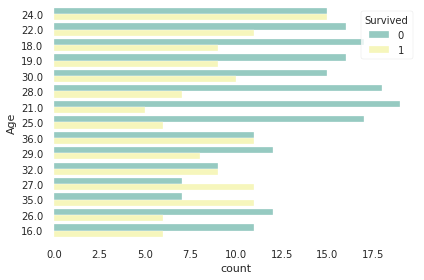

In [12]:
# Ageと目的変数の関係を上位15データで表示
sns.countplot(data=train, y='Age', hue='Survived', order = train['Age'].value_counts().index[:15], palette='Set3')
plt.legend(loc='upper right', title='Survived')
plt.tight_layout()

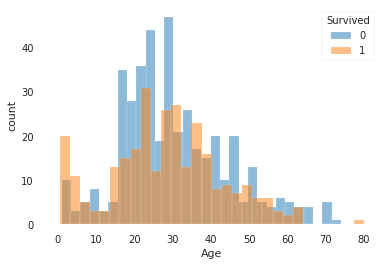

In [13]:
# 上記のグラフが見づらいので別な表示方法でAgeと目的変数の関係（全体を表示）
plt.hist(train.loc[train['Survived'] == 0, 'Age'].dropna(), bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Age'].dropna(), bins=30, alpha=0.5, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived')
plt.show()

20から30歳の人の生存率が特に低いです。

data count
 0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
Null count  0


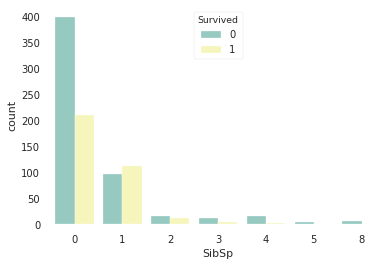

In [14]:
# SibSp配偶者の数と目的変数との関係=
print('data count\n', train['SibSp'].value_counts())
print('Null count ', train['SibSp'].isnull().sum())
sns.countplot(data=train, x='SibSp', hue='Survived', palette='Set3')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


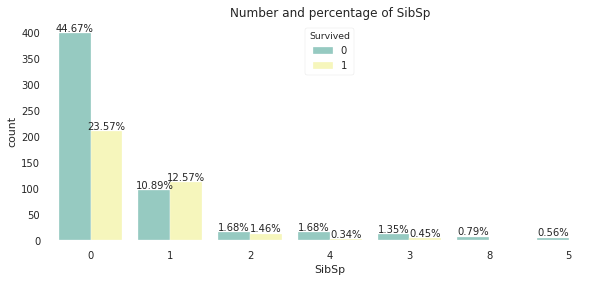

In [15]:
plot_count2(df=train, feature='SibSp', hue='Survived', title='SibSp', size=2.5)

配偶者が0と3以上のデータは生存率が低いです。

posx and posy should be finite values
posx and posy should be finite values


data count
 0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
Null count  0


posx and posy should be finite values
posx and posy should be finite values


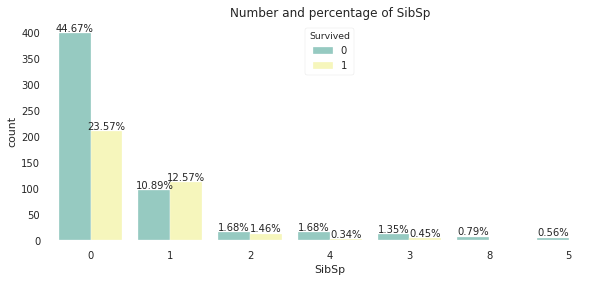

In [16]:
# Parchと目的変数との関係
print('data count\n', train['Parch'].value_counts())
print('Null count ', train['Parch'].isnull().sum())

plot_count2(df=train, feature='SibSp', hue='Survived', title='SibSp', size=2.5)
# sns.countplot(data=train, x='Parch', hue='Survived', palette='Set3')

親子数が4人以上になると生存率が低くなっています。

ParchとSibSpには同乗する家族の人数に関する特徴量となっています。
人数が増えると生存率が下がるという共通点もあり、「両者を足し合わせて『家族の人数』という特徴量を新たに作ると、予測性能に寄与する可能性がある」という仮説を立てます。

data count
 Float64Index([8.05, 13.0, 7.8958, 7.75, 26.0, 10.5, 7.925, 7.775, 0.0, 7.2292], dtype='float64')
Null count  0


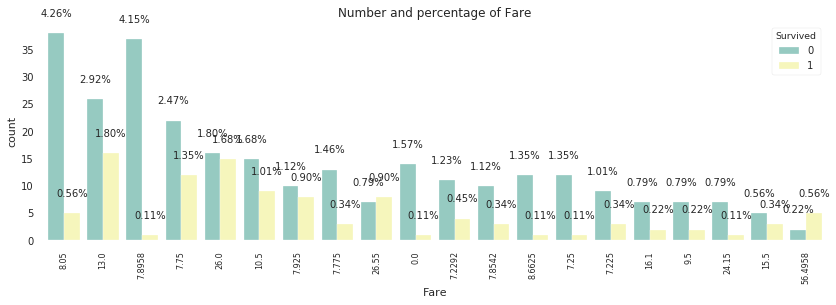

In [17]:
# Fareと目的変数との関係
print('data count\n', train['Fare'].value_counts().sort_values(ascending=False).index[:10])
print('Null count ', train['Fare'].isnull().sum())

plot_count2(df=train, feature='Fare', hue='Survived', title='Fare', size=3.5)

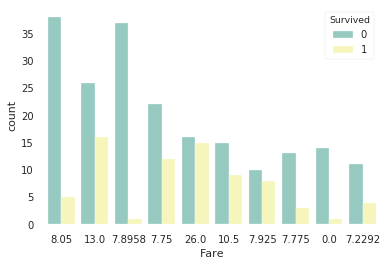

In [18]:
sns.countplot(data=train, x='Fare', hue='Survived', order=train['Fare'].value_counts().sort_values(ascending=False).index[:10], palette='Set3')

(-5, 250)

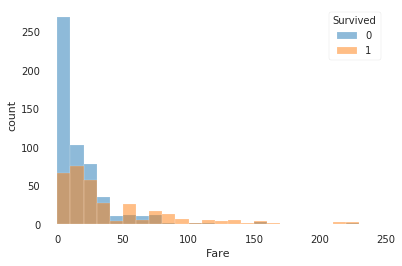

In [19]:
# Fareと目的変数との関係
plt.hist(train.loc[train['Survived'] == 0, 'Fare'].dropna(), range=(0, 250), bins=25, alpha=0.5, label='0') 
plt.hist(train.loc[train['Survived'] == 1, 'Fare'].dropna(), range=(0, 250), bins=25, alpha=0.5, label='1') 
plt.xlabel('Fare')
plt.ylabel('count')
plt.legend(title='Survived')
plt.xlim(-5, 250)

運賃ごとの生存率は30以下の乗客の生存率が低く、その中でも特に10以下の乗客の生存率が低くなっています。

data count
 3    491
1    216
2    184
Name: Pclass, dtype: int64
Null count  0


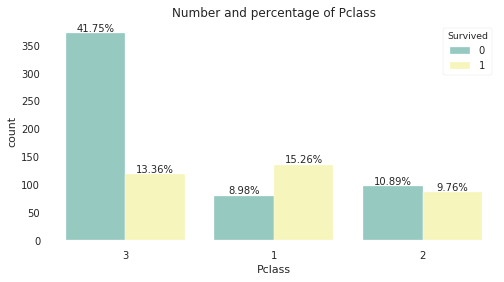

In [20]:
# Pclassチケットクラスと目的変数との関係
print('data count\n', train['Pclass'].value_counts())
print('Null count ', train['Pclass'].isnull().sum())

plot_count2(df=train, feature='Pclass', hue='Survived', title='Pclass', size=2)

Pclassが増えるごとに生存率が下がることが分かります。

data count
 male      577
female    314
Name: Sex, dtype: int64
Null count  0


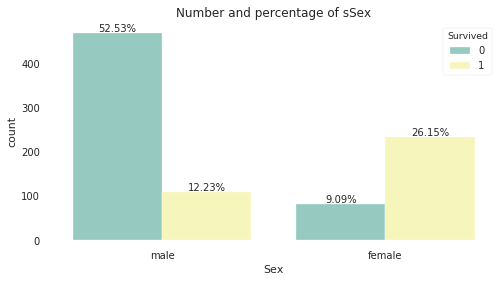

In [21]:
# Sexと目的変数との関係
print('data count\n', train['Sex'].value_counts())
print('Null count ', train['Sex'].isnull().sum())

plot_count2(df=train, feature='Sex', hue='Survived', title='sSex', size=2)
# sns.countplot(x='Sex', hue='Survived', data=train)

男性の生存率が低く、女性の生存率が高いことから性別は重要な特徴量ということができそうです。

data count
 S    644
C    168
Q     77
Name: Embarked, dtype: int64
Null count  2


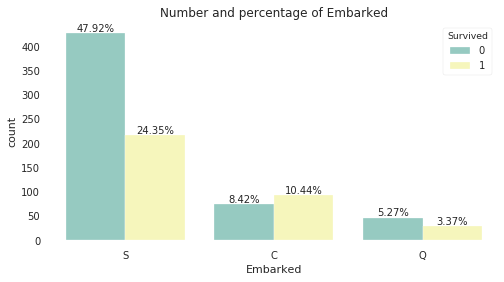

In [22]:
# Embarked出港地と目的変数との関係
print('data count\n', train['Embarked'].value_counts())
print('Null count ', train['Embarked'].isnull().sum())

plot_count2(df=train, feature='Embarked', hue='Survived', title='Embarked', size=2)

SとQの生存率が低く、Cの生存率が高いです。

## 仮説から新しい特徴量を作る

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


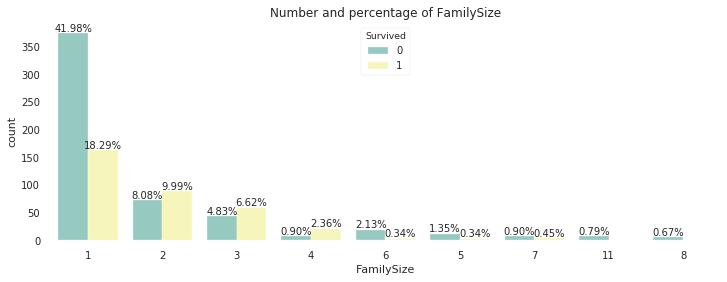

In [23]:
# ParchとSibSpを足し合わせてFamilySizeを新しく作成
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
test['FamilySize'] = test['Parch'] + test['SibSp'] + 1

# 表示確認の可視化
plot_count2(df=train, feature='FamilySize', hue='Survived', title='FamilySize', size=3)

FamilySizeが5人以上になると生存率が低く、1人の人の割合が多く、そして生存率が低いです。<br>この家族数が1であることも予測に寄与しそうなので、下記のように特徴量を作りました

In [24]:
# 家族数1の特徴量IsAloneを作成
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1    # 行がtrain['FamilySize'] == 1のとき'IsaAlone'を1に

test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

## 欠損値の処理

In [25]:
# データの縦連結
data = pd.concat([train, test], sort=False)
data.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  FamilySize  IsAlone  
0      0         A/5 21171   7.2500   NaN        S           2        0  
1      0          PC 17599  71.2833   C85        C           2        0  
2      0  STON/O2. 3101282   7.9250   NaN        S           1        1  
3      0            113803  53.1000  C123        S           2        0  
4      0            373450   8.0500   NaN        S           1        1

In [26]:
# 欠損値の確認
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
FamilySize        0
IsAlone           0
dtype: int64

In [27]:
# データ形式の確認
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  FamilySize   1309 non-null   int64  
 13  IsAlone      1309 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 153.4+ KB


In [28]:
# 年齢を中央値で補完
data['Age'].fillna(data['Age'].median(), inplace=True)

In [29]:
# 運賃を平均で補完
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

In [30]:
# 頻度（出現回数）をカウント
print(data['Embarked'].value_counts())

# 欠損値はSとして補完
data['Embarked'].fillna(('S'), inplace=True)
# S=0 C=1 Q=2 にint型で変換
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

# 変換後の型の確認
data['Embarked'].dtype

S    914
C    270
Q    123
Name: Embarked, dtype: int64


dtype('int64')

In [31]:
# 性別を'male'=0, 'female'=1で変換
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(int)

In [32]:
# 上記のラベルエンコーディングをまとめて実行するなら
# from sklearn.preprocessing import LabelEncoder

# # それぞれのカテゴリ変数にlabel encodingを適用する
# for c in ['Sex', 'Embarked']:
#     # 学習データに基づいてどう変換するかを定める
#     le = LabelEncoder()
#     le.fit(data[c].fillna('NA'))

#     # 学習データ、テストデータを変換する
#     data[c] = le.transform(data[c].fillna('NA'))

In [33]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
IsAlone           0
dtype: int64

## データを訓練データとテストデータに再分割

In [34]:
# 学習に使用しないカラムリストの作成
del_colum = ['PassengerId', 'Name', 'Ticket', 'Cabin']
data.drop(del_colum, axis=1, inplace=True)
# 結合していたデータを再度訓練データとテストデータに分割
train = data[:len(train)]
test = data[len(train):]

# 目的変数と説明変数に分割
y_train = train['Survived']    # 目的変数
X_train = train.drop('Survived', axis=1)    # 訓練データの説明変数
X_test = test.drop('Survived', axis=1)    # テストデータの説明変数

In [35]:
print(X_train.shape, y_train.shape, X_test.shape)

(891, 9) (891,) (418, 9)


In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked    891 non-null    int64  
 7   FamilySize  891 non-null    int64  
 8   IsAlone     891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 69.6 KB


## LightGBMによる学習

事前準備として以下の内容が必要です。

1. 学習用・検証用にデータセットを分割する
2. カテゴリー変数をリスト形式で宣言する

In [37]:
# 学習用データを学習用・検証用に分割する
from sklearn.model_selection import train_test_split

# train:valid = 7:3
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,             # 対象データ1
    y_train,             # 対象データ2
    test_size=0.3,       # 検証用データを3に指定
    stratify=y_train,    # 訓練データで層化抽出
    random_state=42
)

In [38]:
# カテゴリー変数をリスト形式で宣言(A-Z順で宣言する)
categorical_features = ['Embarked', 'Pclass', 'Sex']

In [39]:
# LightGBMで学習の実施
import lightgbm as lgb
# データセットの初期化
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=categorical_features
)

lgb_valid = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,    # 検証用データで参照として使用する訓練データの指定
    categorical_feature=categorical_features
)

# パラメータの設定
params = {
    'objective':'binary'    # logistic –バイナリ分類のロジスティック回帰 (多値分類ならmultiでsoftmax)
}

lgb_model = lgb.train(
    params,    # パラメータ
    lgb_train,    # 学習用データ
    valid_sets=[lgb_train, lgb_valid],    # 訓練中に評価されるデータ
    verbose_eval=10,    # 検証データは10個
    num_boost_round=1000,    # 学習の実行回数の最大値
    early_stopping_rounds=10    # 連続10回学習で検証データの性能が改善しない場合学習を打ち切る
)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [40]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(X_train.columns) # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(lgb_model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

feature  importance
5        Fare    0.431002
2         Age    0.317580
0      Pclass    0.075614
6    Embarked    0.058601
1         Sex    0.047259
7  FamilySize    0.045369
3       SibSp    0.013233
4       Parch    0.007561
8     IsAlone    0.003781

Text(0, 0.5, 'Feature')

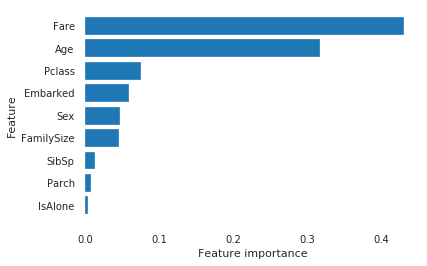

In [41]:
# 特徴量重要度の可視化
n_features = len(df_importance) # 特徴量数(説明変数の個数) 
df_plot = df_importance.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
plt.barh(range(n_features), f_imoprtance_plot, align='center') 
cols_plot = df_plot['feature'].values # 特徴量の取得 
plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
plt.xlabel('Feature importance') # x軸のタイトル
plt.ylabel('Feature') # y軸のタイトル

In [42]:
# 推論                 
lgb_y_pred = lgb_model.predict(
    X_test,    # 予測を行うデータ
    num_iteration=lgb_model.best_iteration, # 繰り返しのインデックス Noneの場合、best_iterationが存在するとダンプされます。それ以外の場合、すべての繰り返しがダンプされます。 <= 0の場合、すべての繰り返しがダンプされます。
)
# 結果の表示
lgb_y_pred[:10]

array([0.07860435, 0.3865988 , 0.08984265, 0.14226353, 0.45995567,
       0.27467088, 0.68844681, 0.16335787, 0.80446021, 0.13201123])

In [43]:
# 予測結果の0.5を閾値として2値分類
lgb_y_pred = (lgb_y_pred > 0.5).astype(int)
# 結果の表示
lgb_y_pred[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [44]:
# 予測データをcsvに変換
sub = pd.read_csv('./data/titanic/gender_submission.csv')    # サンプルの予測データ
sub['Survived'] = lgb_y_pred

sub.to_csv('./data/titanic/submit_lightgbm.csv', index=False)
sub.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

## ハイパーパラメーターの調整

ハイパーパラメーターのチューニングツールoptunaを使用してハイパーパラメーターを調整します。
指定方法は[optuna.trial](https://optuna.readthedocs.io/en/latest/reference/trial.html)で確認します。
- `max_bin`:各特長量の最大の分割数
- `num_leaves`:1つの決定木における分岐の末端の最大数
- `learning_rate`:テーブルデータでは一般的に学習率が低く丁寧に学習を行うほど高い性能を得られるため探索範囲は設定せず手動で調整を行うようにします。

In [45]:
import optuna
from sklearn.metrics import log_loss    # 評価指標としてcross entropyを使用します（予測と正解の確率分布の誤差を確認）

# カテゴリー変数をリスト形式で宣言(A-Z順で宣言する)
categorical_features = ['Embarked', 'Pclass', 'Sex']

# 学習内容の定義
def objective(trial):
    # パラメータの設定
    param = {
        'objective': 'binary',    # logistic –バイナリ分類のロジスティック回帰 (多値分類ならmultiでsoftmax)
        'metric': 'binary_logloss',
        'max_bin':trial.suggest_int('max_bin', 100, 500),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate':0.01,
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'num_leaves': trial.suggest_int('num_leaves', 32, 128)
    }
    # データセットの初期化
    lgb_train = lgb.Dataset(
        X_train,
        y_train,
        categorical_feature=categorical_features
    )

    lgb_valid = lgb.Dataset(
        X_valid,
        y_valid,
        reference=lgb_train,    # 検証用データで参照として使用する訓練データの指定
        categorical_feature=categorical_features
    )

    model = lgb.train(
        params,    # パラメータ
        lgb_train,    # 学習用データ
        valid_sets=[lgb_train, lgb_valid],    # 訓練中に評価されるデータ
        verbose_eval=10,    # 検証データは10個
        num_boost_round=1000,    # 学習の実行回数の最大値
        early_stopping_rounds=10    # 連続10回学習で検証データの性能が改善しない場合学習を打ち切る
    )

    # 推論                 
    y_pred = model.predict(
        X_valid,    # 予測を行うデータ
        num_iteration=model.best_iteration, # 繰り返しのインデックス Noneの場合、best_iterationが存在するとダンプされます。それ以外の場合、すべての繰り返しがダンプされます。 <= 0の場合、すべての繰り返しがダンプされます。
    )
    # 評価
    score = log_loss(
        y_valid,    # 正解値
        y_pred      # 予測結果
    )
    return score

In [46]:
# ハイパーパラメーターチューニングの実行
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=40)

/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:54,823] Finished trial#0 with value: 0.43090162831806855 with parameters: {'max_bin': 202, 'lambda_l1': 0.14753222142907674, 'lambda_l2': 4.4762373716945623e-07, 'num_leaves': 73, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorica

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:55,054] Finished trial#1 with value: 0.43090162831806855 with parameters: {'max_bin': 187, 'lambda_l1': 1.0078073009989046e-05, 'lambda_l2': 1.931084870540406e-07, 'num_leaves': 132, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categ

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:55,295] Finished trial#2 with value: 0.43090162831806855 with parameters: {'max_bin': 485, 'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves': 205, 'feature_fraction': 0.7669918962929685, 'bagging_fraction': 0.40423978313183045, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categ

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:55,568] Finished trial#3 with value: 0.43090162831806855 with parameters: {'max_bin': 158, 'lambda_l1': 3.9696182670988566e-05, 'lambda_l2': 2.630213296503227e-08, 'num_leaves': 189, 'feature_fraction': 0.619817105976215, 'bagging_fraction': 0.6736419905302216, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categor

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:55,848] Finished trial#4 with value: 0.43090162831806855 with parameters: {'max_bin': 463, 'lambda_l1': 0.00042472707398058225, 'lambda_l2': 0.0021465011216654484, 'num_leaves': 132, 'feature_fraction': 0.9159642440417923, 'bagging_fraction': 0.8081845231526679, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using catego

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:56,088] Finished trial#5 with value: 0.43090162831806855 with parameters: {'max_bin': 487, 'lambda_l1': 3.0186711293150927, 'lambda_l2': 0.0011737996092661858, 'num_leaves': 251, 'feature_fraction': 0.5827682615040224, 'bagging_fraction': 0.45860326840383037, 'bagging_freq': 4, 'min_child_samples': 96}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:56,344] Finished trial#6 with value: 0.43090162831806855 with parameters: {'max_bin': 363, 'lambda_l1': 2.039373116525212e-08, 'lambda_l2': 1.527156759251193, 'num_leaves': 165, 'feature_fraction': 0.5093416526728374, 'bagging_fraction': 0.8532168461905915, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:56,577] Finished trial#7 with value: 0.43090162831806855 with parameters: {'max_bin': 205, 'lambda_l1': 0.0012861835488952368, 'lambda_l2': 1.9134610757932285e-08, 'num_leaves': 147, 'feature_fraction': 0.8650796940166687, 'bagging_fraction': 0.9636993649385135, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using catego

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:56,805] Finished trial#8 with value: 0.43090162831806855 with parameters: {'max_bin': 403, 'lambda_l1': 8.686941947564378e-06, 'lambda_l2': 0.0013614314210463002, 'num_leaves': 253, 'feature_fraction': 0.4271363733463229, 'bagging_fraction': 0.5951981984579586, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categor

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:57,029] Finished trial#9 with value: 0.43090162831806855 with parameters: {'max_bin': 379, 'lambda_l1': 1.6247252885719427e-05, 'lambda_l2': 3.376063348877853e-06, 'num_leaves': 125, 'feature_fraction': 0.565599509213526, 'bagging_fraction': 0.5777641034224494, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categor

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:57,287] Finished trial#10 with value: 0.43090162831806855 with parameters: {'max_bin': 426, 'lambda_l1': 6.465666894158905e-05, 'lambda_l2': 3.5804174374946304e-05, 'num_leaves': 137, 'feature_fraction': 0.4033132702741615, 'bagging_fraction': 0.8892768570729005, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categ

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:57,509] Finished trial#11 with value: 0.43090162831806855 with parameters: {'max_bin': 388, 'lambda_l1': 0.0028421027381422648, 'lambda_l2': 2.1712403768319937, 'num_leaves': 251, 'feature_fraction': 0.4695214357150779, 'bagging_fraction': 0.9178620555253562, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:57,750] Finished trial#12 with value: 0.43090162831806855 with parameters: {'max_bin': 147, 'lambda_l1': 2.17452432291623e-05, 'lambda_l2': 0.010460953556739525, 'num_leaves': 38, 'feature_fraction': 0.8377637070028385, 'bagging_fraction': 0.7825344828131279, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:57,983] Finished trial#13 with value: 0.43090162831806855 with parameters: {'max_bin': 326, 'lambda_l1': 1.1921975182604538e-07, 'lambda_l2': 0.02625445968759339, 'num_leaves': 2, 'feature_fraction': 0.8330377126989239, 'bagging_fraction': 0.5415909518493734, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:58,219] Finished trial#14 with value: 0.43090162831806855 with parameters: {'max_bin': 306, 'lambda_l1': 7.04480806377519e-05, 'lambda_l2': 1.6934490731313353e-08, 'num_leaves': 206, 'feature_fraction': 0.5210315214012378, 'bagging_fraction': 0.9374581574041116, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using catego

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:58,442] Finished trial#15 with value: 0.43090162831806855 with parameters: {'max_bin': 487, 'lambda_l1': 1.4726456718740824, 'lambda_l2': 1.7523871598466864e-06, 'num_leaves': 238, 'feature_fraction': 0.723904654781004, 'bagging_fraction': 0.5218367348408617, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:58,698] Finished trial#16 with value: 0.43090162831806855 with parameters: {'max_bin': 286, 'lambda_l1': 0.017908713854647627, 'lambda_l2': 0.8398670653892879, 'num_leaves': 171, 'feature_fraction': 0.8848722277386502, 'bagging_fraction': 0.7800422539062541, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorica

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:58,934] Finished trial#17 with value: 0.43090162831806855 with parameters: {'max_bin': 207, 'lambda_l1': 4.776728196949699e-07, 'lambda_l2': 1.0790237065789294, 'num_leaves': 76, 'feature_fraction': 0.5946070126031644, 'bagging_fraction': 0.473252772820404, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:59,152] Finished trial#18 with value: 0.43090162831806855 with parameters: {'max_bin': 484, 'lambda_l1': 1.1256839212661599e-06, 'lambda_l2': 6.98184330520185e-05, 'num_leaves': 117, 'feature_fraction': 0.6115413138005015, 'bagging_fraction': 0.5828687548948175, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using catego

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:59,385] Finished trial#19 with value: 0.43090162831806855 with parameters: {'max_bin': 236, 'lambda_l1': 0.00023092435658024003, 'lambda_l2': 0.01705785019386454, 'num_leaves': 235, 'feature_fraction': 0.6025691028421768, 'bagging_fraction': 0.9657458223475115, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categor

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:59,609] Finished trial#20 with value: 0.43090162831806855 with parameters: {'max_bin': 332, 'lambda_l1': 4.310479058608916e-05, 'lambda_l2': 3.837339498702259e-08, 'num_leaves': 187, 'feature_fraction': 0.9774683769652668, 'bagging_fraction': 0.5510693774952184, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categor

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:17:59,849] Finished trial#21 with value: 0.43090162831806855 with parameters: {'max_bin': 180, 'lambda_l1': 2.5178457960230647e-06, 'lambda_l2': 6.159346018646987, 'num_leaves': 221, 'feature_fraction': 0.4308872507499936, 'bagging_fraction': 0.5671878785419668, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorica

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:00,062] Finished trial#22 with value: 0.43090162831806855 with parameters: {'max_bin': 225, 'lambda_l1': 2.0139739500176936e-07, 'lambda_l2': 0.0002541410632209718, 'num_leaves': 161, 'feature_fraction': 0.7317358534427968, 'bagging_fraction': 0.7556180343276362, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categ

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:00,281] Finished trial#23 with value: 0.43090162831806855 with parameters: {'max_bin': 222, 'lambda_l1': 1.5116089146878039e-06, 'lambda_l2': 0.16914447150446982, 'num_leaves': 70, 'feature_fraction': 0.7793834983561476, 'bagging_fraction': 0.7801178264565368, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categori

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:00,516] Finished trial#24 with value: 0.43090162831806855 with parameters: {'max_bin': 300, 'lambda_l1': 7.709400093120135e-06, 'lambda_l2': 4.771628167351996e-07, 'num_leaves': 94, 'feature_fraction': 0.9150152828882319, 'bagging_fraction': 0.5955753431211308, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categor

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:00,782] Finished trial#25 with value: 0.43090162831806855 with parameters: {'max_bin': 246, 'lambda_l1': 1.3740226301938833e-05, 'lambda_l2': 7.338190127218508e-08, 'num_leaves': 234, 'feature_fraction': 0.8145626428614796, 'bagging_fraction': 0.6320412077803225, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using catego

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:01,017] Finished trial#26 with value: 0.43090162831806855 with parameters: {'max_bin': 250, 'lambda_l1': 0.0007465033559261471, 'lambda_l2': 0.018283510861794135, 'num_leaves': 8, 'feature_fraction': 0.7959904276205074, 'bagging_fraction': 0.8903333201207295, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:01,277] Finished trial#27 with value: 0.43090162831806855 with parameters: {'max_bin': 484, 'lambda_l1': 6.885332382888648e-08, 'lambda_l2': 1.188343025435737, 'num_leaves': 38, 'feature_fraction': 0.9295818059136038, 'bagging_fraction': 0.5132242650048277, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:01,562] Finished trial#28 with value: 0.43090162831806855 with parameters: {'max_bin': 307, 'lambda_l1': 1.1857478328321251, 'lambda_l2': 0.9633360624447911, 'num_leaves': 121, 'feature_fraction': 0.9326620592565759, 'bagging_fraction': 0.9105570692605076, 'bagging_freq': 1, 'min_child_samples': 76}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:01,837] Finished trial#29 with value: 0.43090162831806855 with parameters: {'max_bin': 203, 'lambda_l1': 0.0028698654570754596, 'lambda_l2': 1.2099668294649193e-08, 'num_leaves': 255, 'feature_fraction': 0.9640800654746671, 'bagging_fraction': 0.9841983020531904, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categ

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:02,104] Finished trial#30 with value: 0.43090162831806855 with parameters: {'max_bin': 409, 'lambda_l1': 0.00010859686468951418, 'lambda_l2': 8.914914112873694, 'num_leaves': 229, 'feature_fraction': 0.8273075328085215, 'bagging_fraction': 0.5423494524980801, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:02,384] Finished trial#31 with value: 0.43090162831806855 with parameters: {'max_bin': 483, 'lambda_l1': 0.04983502810350691, 'lambda_l2': 0.0307935187541101, 'num_leaves': 129, 'feature_fraction': 0.7409851620012831, 'bagging_fraction': 0.4562048606968555, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:02,665] Finished trial#32 with value: 0.43090162831806855 with parameters: {'max_bin': 337, 'lambda_l1': 0.0020362806204570873, 'lambda_l2': 6.457073418603503, 'num_leaves': 52, 'feature_fraction': 0.935227933106268, 'bagging_fraction': 0.7786831755983578, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:02,906] Finished trial#33 with value: 0.43090162831806855 with parameters: {'max_bin': 196, 'lambda_l1': 0.0015564492396416625, 'lambda_l2': 0.00027080659985063754, 'num_leaves': 198, 'feature_fraction': 0.5381111609449332, 'bagging_fraction': 0.6995160279308514, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categ

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:03,142] Finished trial#34 with value: 0.43090162831806855 with parameters: {'max_bin': 148, 'lambda_l1': 2.4685046280564666e-08, 'lambda_l2': 8.932120990063831, 'num_leaves': 159, 'feature_fraction': 0.9723571462015524, 'bagging_fraction': 0.9489186341322691, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categoric

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:03,390] Finished trial#35 with value: 0.43090162831806855 with parameters: {'max_bin': 448, 'lambda_l1': 7.139327996351564e-05, 'lambda_l2': 5.010641965202524, 'num_leaves': 100, 'feature_fraction': 0.9881989502296274, 'bagging_fraction': 0.4452077536036769, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorica

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:03,625] Finished trial#36 with value: 0.43090162831806855 with parameters: {'max_bin': 260, 'lambda_l1': 7.117017708017735e-06, 'lambda_l2': 3.353009007953809e-07, 'num_leaves': 26, 'feature_fraction': 0.6368148800856833, 'bagging_fraction': 0.9065278844357868, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categor

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:04,125] Finished trial#37 with value: 0.43090162831806855 with parameters: {'max_bin': 213, 'lambda_l1': 0.0034281912357116743, 'lambda_l2': 8.137381007150568, 'num_leaves': 195, 'feature_fraction': 0.5524981894418433, 'bagging_fraction': 0.5771743530513632, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorica

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:04,571] Finished trial#38 with value: 0.43090162831806855 with parameters: {'max_bin': 492, 'lambda_l1': 0.021006647887921025, 'lambda_l2': 1.7195719847367482e-05, 'num_leaves': 222, 'feature_fraction': 0.5779060861886791, 'bagging_fraction': 0.6518685138677659, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial#0 with value: 0.43090162831806855.
/opt/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:722: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 256, 'step': 1}
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using catego

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422741	valid_1's binary_logloss: 0.473803
[20]	training's binary_logloss: 0.348287	valid_1's binary_logloss: 0.436192
[30]	training's binary_logloss: 0.295311	valid_1's binary_logloss: 0.438697
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.32933	valid_1's binary_logloss: 0.430902


[I 2020-07-01 10:18:04,866] Finished trial#39 with value: 0.43090162831806855 with parameters: {'max_bin': 112, 'lambda_l1': 5.424348994336952e-08, 'lambda_l2': 1.1134321697373643e-08, 'num_leaves': 37, 'feature_fraction': 0.8789771073800651, 'bagging_fraction': 0.7899783584666591, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial#0 with value: 0.43090162831806855.


In [47]:
# ベストパラメーターの表示
study.best_params

{'max_bin': 202,
 'lambda_l1': 0.14753222142907674,
 'lambda_l2': 4.4762373716945623e-07,
 'num_leaves': 73,
 'feature_fraction': 0.759195090518222,
 'bagging_fraction': 0.4936111842654619,
 'bagging_freq': 3,
 'min_child_samples': 91}

## optunaのベストパラメーターで再度学習を行う
## 交差検証

In [48]:
# 訓練用と検証用のデータの割合をできるだけそろえるように分割するライブラリ
from sklearn.model_selection import StratifiedKFold

y_preds = []    # 検証結果の格納先
models = []    # モデルのパラメータの格納先
oof_train = np.zeros((len(X_train), ))    # 学習で使用されなかったデータ
# 5分割して交差検証
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# カテゴリー変数をリスト形式で宣言(A-Z順で宣言する)
categorical_features = ['Embarked', 'Pclass', 'Sex']

# パラメータの設定
param = {
    'objective': 'binary',    # logistic –バイナリ分類のロジスティック回帰 (多値分類ならmultiでsoftmax)
    'metric': 'binary_logloss',
    'max_bin':study.best_params['max_bin'],
    'lambda_l1': study.best_params['lambda_l1'],
    'lambda_l2': study.best_params['lambda_l2'],
    'num_leaves': study.best_params['num_leaves'],
    'learning_rate':0.01,
    'feature_fraction': study.best_params['feature_fraction'],
    'bagging_fraction': study.best_params['bagging_fraction'],
    'bagging_freq': study.best_params['bagging_freq'],
    'min_child_samples': study.best_params['min_child_samples'],
    'num_leaves': study.best_params['num_leaves'],
}

for train_index, valid_index in cv.split(X_train, y_train):
    # 訓練データを訓練データとバリデーションデータに分ける
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]    # 分割後の訓練データ
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]    # 分割後の検証データ
    
    # データセットの初期化
    lgb_train = lgb.Dataset(
        X_tr,
        y_tr,
        categorical_feature=categorical_features
    )
    lgb_eval = lgb.Dataset(
        X_val,
        y_val,
        reference=lgb_train,    # 検証用データで参照として使用する訓練データの指定
        categorical_feature=categorical_features
    )
    
    lgb_model = lgb.train(
        params,    # パラメータ
        lgb_train,    # 学習用データ
        valid_sets=[lgb_train, lgb_eval],    # 訓練中に評価されるデータ
        verbose_eval=10,    # 検証データは10個
        num_boost_round=1000,    # 学習の実行回数の最大値
        early_stopping_rounds=10    # 連続10回学習で検証データの性能が改善しない場合学習を打ち切る
    )
    # 検証の実施
    oof_train[valid_index] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    # 予測の実施
    y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    
    y_preds.append(y_pred)
    models.append(lgb_model)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.422998	valid_1's binary_logloss: 0.508459
[20]	training's binary_logloss: 0.337719	valid_1's binary_logloss: 0.48218
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.347239	valid_1's binary_logloss: 0.480962
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.431849	valid_1's binary_logloss: 0.501286
[20]	training's binary_logloss: 0.352316	valid_1's binary_logloss: 0.47178
[30]	training's binary_logloss: 0.301786	valid_1's binary_logloss: 0.457364
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.31397	valid_1's binary_logloss: 0.45349
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.431609	valid_1's binary_logloss: 0.479409
[20]	training's binary_logloss: 0.350361	valid_1's binary_logloss: 0.442773
[30]	training's binary_logloss: 0.294474	valid_1's binary_logloss: 

In [49]:
# 検証データをCSVファイルとして保存
pd.DataFrame(oof_train).to_csv('./data/titanic/oof_train_skfold.csv', index=False)
print(oof_train[:10])    # 検証結果の表示
scores = [
    m.best_score['valid_1']['binary_logloss'] for m in models
]
score = sum(scores) / len(scores)

print('===CV scores===')
# 交差検証ごとの結果
print(scores)
# 交差検証の結果の平均
print(score)

[0.49908765 0.05954585 0.77581415 0.00595568 0.07495125 0.98515338
 0.23727641 0.10245367 0.12529287 0.13151262]
===CV scores===
[0.4809617105747218, 0.453490281140324, 0.432729040463232, 0.33928611383433094, 0.3844032027001554]
0.41817406974255283


In [50]:
# 正解率の表示
from sklearn.metrics import accuracy_score

y_pred_oof = (oof_train > 0.5).astype(int)

print("LightGBMの正解率 : {:.2f}".format(accuracy_score(y_train, y_pred_oof)))

LightGBMの正解率 : 0.83


In [51]:
y_sub = sum(y_preds) / len(y_preds)
y_sub_lgb = (y_sub > 0.5).astype(int)
y_sub_lgb[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [52]:
# 予測データをcsvに変換
sub_lgb = pd.DataFrame({'PassengerId': sub['PassengerId'], 'Survived': y_sub_lgb})
sub_lgb.to_csv('./data/titanic/submission_lightgbm_skfold.csv', index=False)

sub_lgb.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

## Pytorchによる学習

In [53]:
import random
import torch

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

In [54]:
# デバイスモードの取得
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)    # デバイスモードの確認

cpu


In [55]:
print(X_train.isnull().sum(), y_train.isnull().sum(), X_test.isnull().sum())

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
IsAlone       0
dtype: int64 0 Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
IsAlone       0
dtype: int64


## データをテンソルに変換

In [56]:
# データをNumpy配列に変換
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
# データをテンソルに変換
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_test = torch.from_numpy(X_test).float().to(device)

## ディープニューラルネットワークのモデル設計

In [57]:
import torch.nn as nn

# 定数
INPUT_SIZE = X_train.shape[1]    # 入力層のニューロン数
HIDDEN_SIZE = 512     # 隠れ層のニューロン数
OUTPUT_CLASSES = 2      # 出力層のニューロン数
DROPOUT_PROBABILITY = 0.5    # ドロップアウト確率

# モデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self):
        # 継承したnn.Module親クラスを初期化
        super(NeuralNetwork, self).__init__()
        # 層の定義
        self.fc1 = nn.Linear(
            INPUT_SIZE,    # 入力層のユニット数
            HIDDEN_SIZE    # 次の層への出力ユニット数
        )
        self.fc2 = nn.Linear(
            HIDDEN_SIZE,   # 隠れ層のユニット数
            HIDDEN_SIZE    # 次の層への出力ユニット数
        )
        self.fc3 = nn.Linear(
            HIDDEN_SIZE,   # 隠れ層のユニット数
            HIDDEN_SIZE    # 次の層への出力ユニット数
        )
        self.fc4 = nn.Linear(
            HIDDEN_SIZE,   # 隠れ層のユニット数
            HIDDEN_SIZE    # 次の層への出力ユニット数
        )
        self.fc5 = nn.Linear(
            HIDDEN_SIZE,   # 隠れ層のユニット数
            OUTPUT_CLASSES # 出力層のニューロン数
        )
        # 活性化関数
        self.relu = nn.ReLU()
        # ドロップアウト層
        self.dropout = nn.Dropout(
            DROPOUT_PROBABILITY  # ドロップアウト層の確率
        )
    def forward(self, x):
        # print('Input_size : ', x.size())    # 出力サイズの確認  debag
        x = self.fc1(x)
        # print('fc1_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.dropout(x)
        # print('fc1_activation_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.fc2(x)
        # print('fc2_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.relu(x)
        # print('fc2_activation_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.fc3(x)
        # print('fc3_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.dropout(x)
        # print('fc3_activation_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.fc4(x)
        # print('fc4_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.relu(x)
        # print('fc4_activation_output_size : ', x.size())    # 出力サイズの確認  debag
        x = self.fc4(x)
        # print('Output_size : ', x.size())    # 出力サイズの確認  debag
        return x

# モデルのインスタンス化
net = NeuralNetwork().to(device)
print(net)                      # モデルの概要を出力

NeuralNetwork(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


### 損失関数の定義<br>オプティマイザー（最適化用オブジェクト）の作成

In [58]:
import torch.optim as optim    # 最適化モジュールのインポート

# 定数
LEARN_RATE = 0.01        # 学習率
# 変数
criterion = nn.CrossEntropyLoss()   # 損失関数：交差エントロピー 学習データの正解率を出力
optimizer = optim.SGD(
        net.parameters(),   # 最適化で更新する重みやバイアスのパラメータ
        lr=LEARN_RATE,        # 学習率
)

## 学習の実行

In [59]:
import time
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset    # データ関連のユーティリティクラスのインポート
from torch.autograd import Variable

def init_parameters(layer):
    """パラメータ（重みとバイアス）の初期化
    引数の層が全結合層の時パラメータを初期化する
    
    Param:
      layer: 層情報
    """
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)    # 重みを「一様分布のランダム値」で初期化
        layer.bias.data.fill_(0.0)               # バイアスを「0」で初期化


net.apply(init_parameters)        # 学習の前にパラメーター初期化

# 定数
start = time.time()             # 実行開始時間の取得
EPOCHS = 1000        # エポック数
BATCH_SIZE = 64        # バッチサイズ

batch_no = len(X_train) // BATCH_SIZE

loss_list = []
acc_list = []

train_loss_min = np.Inf
for epoch in range(EPOCHS):
    # 学習中の損失を格納する変数
    train_loss = 0
    # 学習中の正解数を格納する変数
    correct = 0
    total = 0           # 1ミニバッチ数を格納する変数
    for i in range(batch_no):
        # バッチの開始サイズ
        start = i*BATCH_SIZE
        # バッチの終了サイズ
        end = start+BATCH_SIZE
        # 検証データの取得
        x_var = Variable(torch.FloatTensor(X_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))
        
        # フォワードプロパゲーションで出力結果を取得
        output = net(x_var)
        # 出力結果と正解ラベルから損失を計算し、勾配を計算
        optimizer.zero_grad()    # 勾配を0で初期化
        
        loss = criterion(output, y_var)   # 誤差（出力結果と正解ラベルの差）から損失を取得

        loss.backward()                   # 逆伝播の処理として勾配を計算（自動微分）
        optimizer.step()                  # 最適化の実施
        
        values, labels = torch.max(output, 1)  # 予測した確率の最大値を予測結果として出力
        
        correct += (labels == y_train[start:end]).sum().item()  # 正解数を取得
        total += len(y_train[start:end])              # 1ミニバッチ数の取得

        train_loss += loss.item()*BATCH_SIZE
    
    train_acc = float(correct) / len(X_train)    # 正解率を取得
    # 損失の算出ミニバッチ数分の損失の合計をミニバッチ数で割る
    train_loss = train_loss / len(X_train)
    
    # 損失値を更新したときモデルパラメーターを保存
    if train_loss <= train_loss_min:
        # print("Validation loss decreased ({:6f} ===> {:6f}). Saving the model...".format(train_loss_min,train_loss))
        torch.save(net.state_dict(), './data/titanic/taitanic_model.pt')
        train_loss_min = train_loss
    
    if epoch % 100 == 0:
        # 損失や正解率などの情報を表示
        print(f'[Epoch {epoch+1:3d}/{EPOCHS:3d}]' \
              f' loss: {train_loss:.5f}, acc: {train_acc:.5f}')
    
    # logging
    loss_list.append(train_loss)
    acc_list.append(train_acc)

print('Finished Training')
# 学習終了後、学習に要した時間を出力
print("Computation time:{0:.3f} sec".format(time.time() - start))

# 損失や正解率などの情報を表示
print(f'[Epoch {epoch+1:3d}/{EPOCHS:3d}]' \
      f' loss: {train_loss:.5f}, acc: {train_acc:.5f}')

[Epoch   1/1000] loss: 4.02286, acc: 0.48796
[Epoch 101/1000] loss: 0.56459, acc: 0.64366
[Epoch 201/1000] loss: 0.53855, acc: 0.65329
[Epoch 301/1000] loss: 0.51079, acc: 0.68058
[Epoch 401/1000] loss: 0.47283, acc: 0.71108
[Epoch 501/1000] loss: 0.46737, acc: 0.70787
[Epoch 601/1000] loss: 0.44671, acc: 0.72713
[Epoch 701/1000] loss: 0.44236, acc: 0.74157
[Epoch 801/1000] loss: 0.44524, acc: 0.73034
[Epoch 901/1000] loss: 0.42767, acc: 0.73355
Finished Training
Computation time:1593598364.770 sec
[Epoch 1000/1000] loss: 0.41099, acc: 0.73997


## 正解と損失値の推移グラフ描画

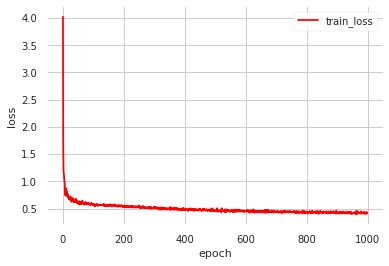

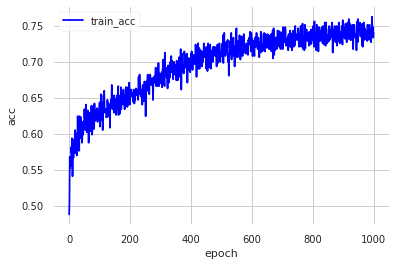

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
plt.plot(range(EPOCHS), loss_list, 'r-', label='train_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(EPOCHS), acc_list, 'b-', label='train_acc')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('acc')
# plt.ylim(0, 1)
plt.grid()

## テストデータで予測

In [61]:
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=False) 
with torch.no_grad():
    test_result = net(X_test_var)
values, labels = torch.max(test_result, 1)
y_sub_nn= labels.data.numpy()
y_sub_nn[:5]

array([0, 0, 0, 0, 0])

In [62]:
# 予測データをcsvに変換
sub_nn = pd.DataFrame({'PassengerId': sub['PassengerId'], 'Survived': y_sub_nn})
sub_nn.to_csv('./data/titanic/submission_nn.csv', index=False)

sub_nn.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

## 予測結果の加重平均をアンサンブルして最終予測結果にする

LightGBMとNN予測結果に加え、RandomForestの予測結果を合計して2以上なら1、それ以外0として結果を取得します。

RandomForestの予測結果を×0.8倍、NN×の予測結果を1.2倍して予測結果にします。

In [63]:
from sklearn.ensemble import RandomForestClassifier
# ジニ不純度を指標とするランダムフォレストのインスタンスを生成
forest = RandomForestClassifier(
    criterion='gini',
    n_estimators=25,
    random_state=42,
    n_jobs=2
)

# 結合していたデータを再度訓練データとテストデータに分割
train = data[:len(train)]
test = data[len(train):]

# 目的変数と説明変数に分割
y_train = train['Survived']    # 目的変数
X_train = train.drop('Survived', axis=1)    # 訓練データの説明変数
X_test = test.drop('Survived', axis=1)    # テストデータの説明変数

# 学習の実施
forest_model = forest.fit(X_train, y_train)

In [64]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'IsAlone'],
      dtype='object')

In [65]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(X_train.columns) # 特徴量名のリスト(目的変数CRIM以外)
f_importance = np.array(forest_model.feature_importances_) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

feature  importance
1         Sex    0.271431
2         Age    0.250881
5        Fare    0.248270
0      Pclass    0.077056
7  FamilySize    0.057703
6    Embarked    0.033065
3       SibSp    0.026276
4       Parch    0.025697
8     IsAlone    0.009623

Text(0, 0.5, 'Feature')

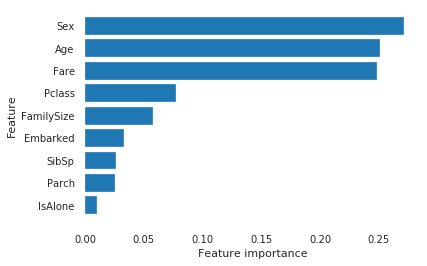

In [66]:
# 特徴量重要度の可視化
n_features = len(df_importance) # 特徴量数(説明変数の個数) 
df_plot = df_importance.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
plt.barh(range(n_features), f_imoprtance_plot, align='center') 
cols_plot = df_plot['feature'].values # 特徴量の取得 
plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
plt.xlabel('Feature importance') # x軸のタイトル
plt.ylabel('Feature') # y軸のタイトル

In [67]:
print("ランダムフォレストの正解率 : {:.2f}".format(forest_model.score(X_train, y_train)))

ランダムフォレストの正解率 : 0.98


In [68]:
# 推論
y_sub_forest = forest_model.predict(X_test)
y_sub_forest[:10]

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0.])

In [69]:
# int型に結果を変換
y_sub_forest = (y_sub_forest > 0.5).astype(int)
y_sub_forest[:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

In [70]:
# 予測データをcsvに変換
sub_forest = pd.DataFrame({'PassengerId': sub['PassengerId'], 'Survived': y_sub_forest})
sub_forest.to_csv('./data/titanic/submission_forest.csv', index=False)

sub_forest.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         1

In [71]:
# LightGBMとNNの予測結果を1つのデータフレームにする
df = pd.DataFrame({'sub_lgbm': sub_lgb['Survived'].values,
                   'sub_forest': sub_forest['Survived'].values,
                   'sub_nn': sub_nn['Survived'].values})
df.head()

sub_lgbm  sub_forest  sub_nn
0         0           0       0
1         0           0       0
2         0           0       0
3         0           1       0
4         0           1       0

In [72]:
df.corr()

sub_lgbm  sub_forest    sub_nn
sub_lgbm    1.000000    0.697007  0.687686
sub_forest  0.697007    1.000000  0.596800
sub_nn      0.687686    0.596800  1.000000

In [73]:
sub = pd.read_csv('./data/titanic/gender_submission.csv')
sub['Survived'] = df['sub_lgbm'] + (0.8 * df['sub_forest']) + (1.2 * df['sub_nn'])
sub.head()

PassengerId  Survived
0          892       0.0
1          893       0.0
2          894       0.0
3          895       0.8
4          896       0.8

In [74]:
sub['Survived'] = (sub['Survived'] >= 2).astype(int)
sub.to_csv('./data/titanic/submission_ensemble.csv', index=False)
sub.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0